# Shopify Data Challenge

Editor: Jack Niu

Email: Jacknjy@hotmail.com

## Question 1 Given some sample data, write a program to answer the following: click here to access the required data set

On Shopify, we have exactly 100 sneaker shops, and each of these shops sells only one model of shoe. We want to do some analysis of the average order value (AOV). When we look at orders data over a 30 day window, we naively calculate an AOV of $3145.13. Given that we know these shops are selling sneakers, a relatively affordable item, something seems wrong with our analysis. 

### a Think about what could be going wrong with our calculation. Think about a better way to evaluate this data. 



Initialize the dataset into a dataframe and check the table details

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [14]:
data = pd.read_excel('Shopify Data Challenge.xlsx')
data.head()

,order_id,shop_id,user_id,order_amount,total_items,payment_method,created_at
0,1,53,746,224,2,cash,2017-03-13 12:36:56.190
1,2,92,925,90,1,cash,2017-03-03 17:38:51.999
2,3,44,861,144,1,cash,2017-03-14 04:23:55.595
3,4,18,935,156,1,credit_card,2017-03-26 12:43:36.649
4,5,18,883,156,1,credit_card,2017-03-01 04:35:10.773


In [15]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   order_id        5000 non-null   int64         
 1   shop_id         5000 non-null   int64         
 2   user_id         5000 non-null   int64         
 3   order_amount    5000 non-null   int64         
 4   total_items     5000 non-null   int64         
 5   payment_method  5000 non-null   object        
 6   created_at      5000 non-null   datetime64[ns]
dtypes: datetime64[ns](1), int64(5), object(1)
memory usage: 273.6+ KB


In [16]:
data.describe()['order_amount']

count      5000.000000
mean       3145.128000
std       41282.539349
min          90.000000
25%         163.000000
50%         284.000000
75%         390.000000
max      704000.000000
Name: order_amount, dtype: float64

From above statistical result, it is quite clear to see that AOV value **3145.13** comes directly from the total average of order amount. The calculation is correct based on the definition of *AOV*. The mistake must happen with insuffcient data preprocessing

When I first saw the result, I was thinking if there could be some duplicate records that affected the final result. For example, one payment with credit card could fail for some reasons (e.g Insufficient Balance, Card Issues, Payment Interuption) and caused the customer to pay several times. If the failure records were kept in the table, it would definitely change the final result. So the first step is to find the duplicate records then clean them out from raw data.

In [17]:
data[data.iloc[:,1:].duplicated(subset = 'created_at', keep = False)].sort_values('created_at')

,order_id,shop_id,user_id,order_amount,total_items,payment_method,created_at
520,521,42,607,704000,2000,credit_card,2017-03-02 04:00:00
4646,4647,42,607,704000,2000,credit_card,2017-03-02 04:00:00
15,16,42,607,704000,2000,credit_card,2017-03-07 04:00:00
2297,2298,42,607,704000,2000,credit_card,2017-03-07 04:00:00
1104,1105,42,607,704000,2000,credit_card,2017-03-24 04:00:00
3332,3333,42,607,704000,2000,credit_card,2017-03-24 04:00:00
2835,2836,42,607,704000,2000,credit_card,2017-03-28 04:00:00
2969,2970,42,607,704000,2000,credit_card,2017-03-28 04:00:00
4056,4057,42,607,704000,2000,credit_card,2017-03-28 04:00:00


From the above result, we could see duplicate payment happened 4 times. It is quite impossible for a same customer(user_id) to make payment at exactly the same time. I would treat these records as illegal and only keep one of each. **Assume the last payment of each duplicate record is successful**.

In [18]:
data.iloc[:,1:].columns

Index(['shop_id', 'user_id', 'order_amount', 'total_items', 'payment_method',
       'created_at'],
      dtype='object')

In [19]:
data.drop_duplicates(subset = ['shop_id', 'user_id', 'order_amount', 'total_items', 'payment_method','created_at'], keep = 'last' , inplace = True)

Also by reviewing the statistical description from above table, we coud see a very high standard deviation, which means the data is highly skewed. The next step is to find the skewed data and see if they are outliers

In [20]:
order_amount_rank = data.groupby(['order_amount']).size().reset_index(name='count').sort_values(by='order_amount', ascending=False)
unique_amount_rank = pd.merge(order_amount_rank, data[['order_amount','total_items']], how = 'left', left_on = 'order_amount', right_on = 'order_amount')
unique_amount_rank.drop_duplicates(inplace = True)
unique_amount_rank['single_price'] = unique_amount_rank['order_amount']/unique_amount_rank['total_items']
unique_amount_rank.head(20)

,order_amount,count,total_items,single_price
0,704000,12,2000,352.0
12,154350,1,6,25725.0
13,102900,1,4,25725.0
14,77175,9,3,25725.0
23,51450,16,2,25725.0
39,25725,19,1,25725.0
58,1760,1,5,352.0
59,1408,2,4,352.0
61,1086,1,6,181.0
62,1064,1,8,133.0


To best find the issues. I picked the top 20 highest order amount from the records and calulated the single price of each sneaker. 

It is possible that a supplier may order large amount of sneakers at one time and then sell them to inidividual customers. In this case, records with order amount **704000** could be possible.

For records with other high order amount (> $2,000), we could see the single prices of the sneakers are equally $25.725, which seems too high for a sneaker (even if it is a limited or collection version or luxury brand). These records needs to be further investigated.

In [21]:
data.loc[data['order_amount'].isin([51450, 25725, 154350, 102900, 77175, 51450, 25725])].sort_values(by='order_amount', ascending=False)

,order_id,shop_id,user_id,order_amount,total_items,payment_method,created_at
691,692,78,878,154350,6,debit,2017-03-27 22:51:43.203
2492,2493,78,834,102900,4,debit,2017-03-04 04:37:33.848
1259,1260,78,775,77175,3,credit_card,2017-03-27 09:27:19.843
3724,3725,78,766,77175,3,credit_card,2017-03-16 14:13:25.868
2906,2907,78,817,77175,3,debit,2017-03-16 03:45:46.089
2690,2691,78,962,77175,3,debit,2017-03-22 07:33:25.104
2564,2565,78,915,77175,3,debit,2017-03-25 01:19:35.410
4192,4193,78,787,77175,3,credit_card,2017-03-18 09:25:31.863
4420,4421,78,969,77175,3,debit,2017-03-09 15:21:34.551
3403,3404,78,928,77175,3,debit,2017-03-16 09:45:04.544


The above result shows the records with sneaker price $25,725 (even cash payment exist with such a high price). All these purchase happened in shop_id 78. In my opinion, either this store is selling some really expensive sneakers or there is a pricing issue. There is also probability that a fraud happens (like the store is doing some money laundrying business). To better figure it out, I suggest we visit this online store and check their products manully.

This case and supplier purchasing could be regarded as special cases. I would not include them to calculate the final result. Next step would be clean these records out from the data.

In [22]:
processed_result = data.loc[data['order_amount'].isin([704000, 51450, 25725, 154350, 102900, 77175, 51450, 25725]) == False].sort_values(by='order_amount', ascending=False)

Text(0.5, 0, 'order_amount')

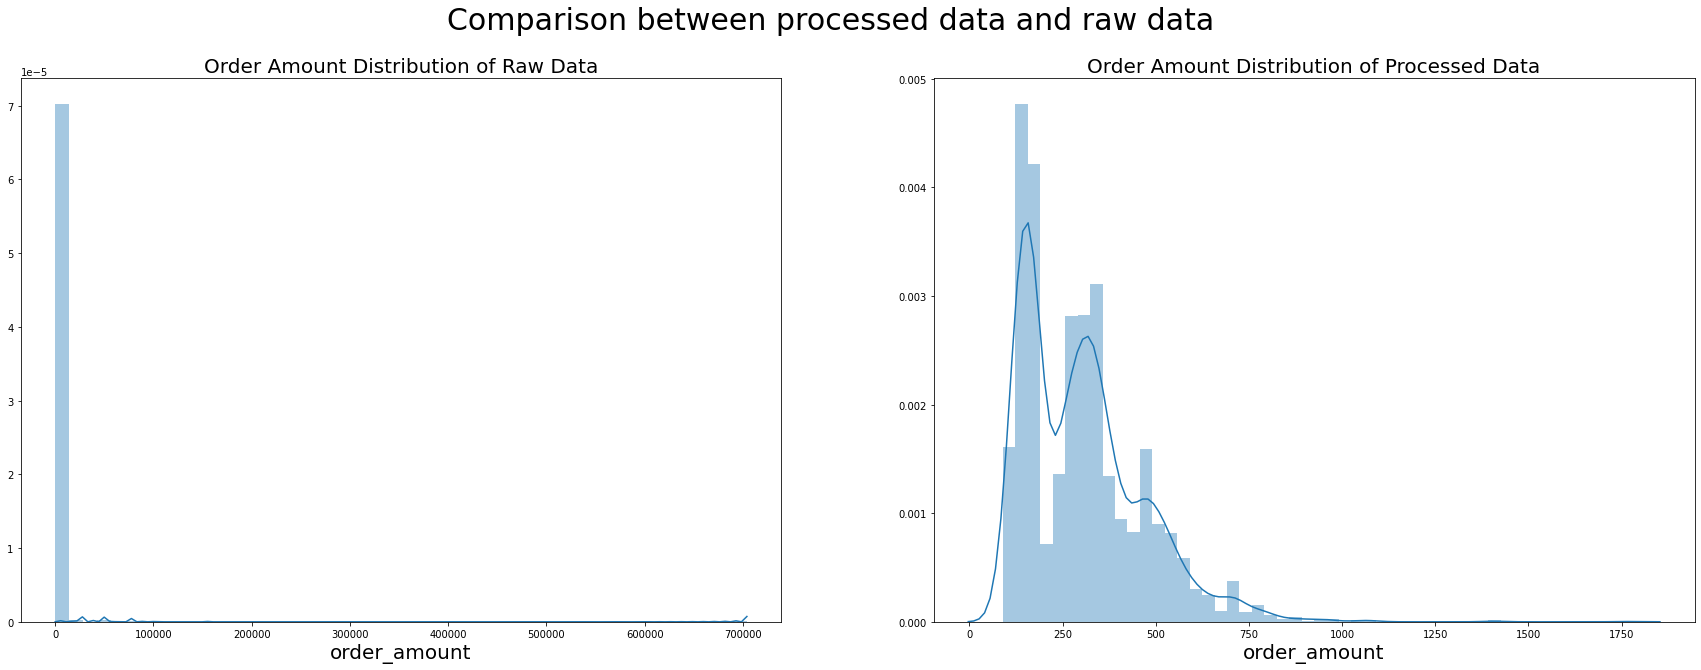

In [24]:
fig, axes = plt.subplots(1,2, figsize = (30,10))
fig.suptitle('Comparison between processed data and raw data',fontsize = 30)

sns.distplot(data['order_amount'],ax = axes[0])
axes[0].set_title('Order Amount Distribution of Raw Data',fontsize = 20)
axes[0].set_xlabel(xlabel = 'order_amount',fontsize = 20)

sns.distplot(processed_result['order_amount'],ax = axes[1])
axes[1].set_title('Order Amount Distribution of Processed Data',fontsize = 20)
axes[1].set_xlabel(xlabel = 'order_amount',fontsize = 20)

**Even though the processed data is still a little right skewed, but the records here are all reasonable and should all be considered for further analysis**

**To best evaluate the performance, I would recommend a few more further analysis:**

1. Check the records with order_amount $704,000 and see if there are indeed a supplier purchasing. If not, we may need to investigate deeper into those records.
2. Generate another dataset that store all B2B records(e.g. supplier purchasing). Since in this dataset we only have one supplier purchasing(need to be confirmed first) and the records are same, we could skip this one.
3. Check if the records exist a secondary sale(i.e. supplier buy products from another supplier and then sell it to customers)
4. Investigate the store that sell extremely high price products.

### b. What metric would you report for this dataset?

Since the processed dataset still has some level of skewness, Mean value will still emphasize some information of the data. Instead of continously using AOV, I would use a more robust metric 'median value' to report for this dataset.

### c. What is its value?

In [25]:
processed_result.describe()['order_amount']

count    4937.000000
mean      302.580514
std       160.804912
min        90.000000
25%       163.000000
50%       284.000000
75%       387.000000
max      1760.000000
Name: order_amount, dtype: float64

**The median value is $284**

## Question 2 SQL Challenge

For this question you’ll need to use SQL. Follow this link to access the data set required for the challenge. Please use queries to answer the following questions. Paste your queries along with your final numerical answers below.

### a. How many orders were shipped by Speedy Express in total?

```
SELECT COUNT(DISTINCT O.OrderID) as NumOfShippment
FROM Orders O LEFT JOIN Shippers S
ON O.ShipperID = S.ShipperID
WHERE S.ShipperName = 'Speedy Express'
```

There are **54** orders were shipped by Speedy Express in total

### b. What is the last name of the employee with the most orders?

```
SELECT E.LastName, COUNT(O.OrderID) AS NumOfOrders
FROM Orders O
LEFT JOIN Employees E
ON O.EmployeeID = E.EmployeeID
GROUP BY E.LastName
ORDER BY 2 DESC
LIMIT 1
```

The last name of the employee with the most orders is **Peacock** with **40** times in total

Sometimes there maybe cases that more than on last names have same number of appearance, which means all of them are the last name with most orders. If we don't identify any rank rules then all these last names should appear in the final result. In this case I would use the following query with **window function**.

```
SELECT LastName, NumOfOrders FROM
(
	SELECT E.LastName, 
	COUNT(O.OrderID) AS NumOfOrders,
	dense_rank() over (ORDER BY COUNT(O.OrderID) DESC) AS LastName_rank
	FROM Orders O
	LEFT JOIN Employees E
	ON O.EmployeeID = E.EmployeeID
	GROUP BY 1
) as tmp
WHERE LastName_rank = 1
```

### c. What product was ordered the most by customers in Germany?


```
SELECT 
P.ProductName, SUM(OD.Quantity) AS TotalQuantity
FROM Orders O LEFT JOIN Customers C ON O.CustomerID = C.CustomerID
LEFT JOIN OrderDetails OD ON O.OrderID = OD.OrderID
LEFT JOIN Products P ON OD.ProductID = P.ProductID
WHERE C.Country = 'Germany'
GROUP BY 1
ORDER BY 2 DESC
LIMIT 1
```

The product that ordered most by customers in Germany is **Boston Crab Meat** with total quantity of **160**.

Similar to question b, if there are more than one product share the same total quantity, all the productName should appear in the result. In this case, I will use the following query with **window function**

```
SELECT ProductName, TotalQuantity
FROM
(
    SELECT 
    P.ProductName, SUM(OD.Quantity) AS TotalQuantity,
    DENSE_RANK() OVER (ORDER BY SUM(OD.Quantity) DESC) AS Quantity_Rank
    FROM Orders O LEFT JOIN Customers C ON O.CustomerID = C.CustomerID
    LEFT JOIN OrderDetails OD ON O.OrderID = OD.OrderID
    LEFT JOIN Products P ON OD.ProductID = P.ProductID
    WHERE C.Country = 'Germany'
    GROUP BY 1
) AS tmp
WHERE Quantity_Rank = 1
```